# Data Split Creation

This notebook creates data splits used to evaluate gRNAde on a set of RNA structures of interest from the PDB identified by [Das et al. (2011)](https://www.nature.com/articles/nmeth.1433), which mainly includes riboswitches, aptamers, and ribozymes.
When benchmarking gRNAde vs. Rosetta, the training and validation data for the gRNAde model explicitly excluded these RNAsas well as any structurally similar RNAs with TM-score threshold of 0.45 (we used US-align for clustering).
Thus, we tried to ensure that gRNAde has not memorized the evaluation dataset for fair comparison.

**Workflow:**
1. Cluster RNA sample sequences into groups based on structural similarity -- qTMclust for efficiently applying US-align with similarity threshold 0.45.
2. Order the clusters based on a metric (median intra-sequence RMSD among available structures within the cluster).
3. Identify the clusters belonging to RNAs identified in the Das et al. (2011) paper.
4. Add all the selected RNAs as well as all other RNAs in the corresponding clusters to the test set (~100 samples).
5. Training and validation splits are semi-randomly split based on the remaining RNAs. Very large (> 1000 nts) RNAs are added to the training set. Validation set RNAs would only come from clusters with less than 5 unique sequences/samples.
4. If any samples were not assigned clusters, append them to the training set.

Note that we separate very large RNA samples (> 1000 nts) from clustering and directly add these to the training set, as it is unlikely that we want to redesign very large RNAs. We do not process very short RNA samples (< 10 nts).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import dotenv
dotenv.load_dotenv("../.env")

True

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import lovely_tensors as lt
lt.monkey_patch()

In [ ]:
DATA_PATH = os.environ.get("DATA_PATH")

In [4]:
seq_to_data = torch.load(os.path.join(DATA_PATH, "processed.pt"))
df = pd.read_csv(os.path.join(DATA_PATH, "processed_df.csv"))
# df["cluster_structsim0.45"] = df["cluster_structsim0.45"].fillna(-1)
# df["cluster_seqid0.8"] = df["cluster_seqid0.8"].fillna(-1)
df

,id_list,rfam_list,eq_class_list,type_list,cluster_seqid0.8,cluster_structsim0.45,sequence,length,mean_rmsd,median_rmsd,num_structures
0,"['6WD5_1_2', '6WD1_1_2', '6WD9_1_2', '6OGI_1_2...","['5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA', '...","['10157', '10157', '10157', '10157', '10157', ...","['Protein-RNA Complex', 'Protein-RNA Complex',...",56,133,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,120,0.879151,0.778740,91
1,['3B58_1_B-C-A'],['unknown'],['02086'],['Solo RNA'],660,283,UCCCAGUCCACCGCGGUGAGAAGGGGGCAGAGAAACACACGAUCGU...,61,0.000000,0.000000,1
2,"['7M57_1_n-Y', '7M57_1_qq-bb', '4OQ9_1_S-h', '...","['unknown', 'unknown', 'unknown', 'unknown', '...","['20373', '20373', '24132', '20373', '20373', ...","['Protein-RNA Complex', 'Protein-RNA Complex',...",39,764,AAAAAAAAAAUUUUUUUUUU,20,0.808048,0.749047,46
3,['6DTI_1_X-W'],['SSU_rRNA_bacteria'],['63494'],['Protein-RNA Complex'],11,929,GGCUACGAACCCGUA,15,0.000000,0.000000,1
4,['3KTW_1_C'],['unknown'],['32874'],['Protein-RNA Complex'],438,171,AGAUAGUCGUGGGUUCCCUUUCUGGAGGGAGAGGGAAUUCCACGUU...,96,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
4218,['354D_1_A-B'],['unknown'],['63943'],['DNA-RNA Hybrid'],1002,656,CCGAUGGUAGUGGCGAGAGUA_C,23,0.000000,0.000000,1
4219,['2DER_1_D'],['tRNA'],['79496'],['Protein-RNA Complex'],567,212,CCCCUUCGUCUAGAGGCCCAGGACACCGCCCUUUCACGGCGGUAAC...,71,0.000000,0.000000,1
4220,['4ILL_1_C'],['unknown'],['31263'],['Protein-RNA Complex'],42,789,GCUAAUCUACUAUAGAA,17,0.000000,0.000000,1
4221,['3T1Y_1_X-W'],['SSU_rRNA_bacteria'],['61644'],['Protein-RNA Complex'],4,1048,AAGGACUUUAC,11,0.000000,0.000000,1


In [6]:
das_list = [
    "1CSL", # RRE high affinity site
    "1ET4", # Vitamin B12 binding RNA aptamer
    "1F27", # Biotin-binding RNA pseudoknot
    "1L2X", # Viral RNA pseudoknot
    "1LNT", # RNA internal loop of SRP
    "1Q9A", # Sarcin/ricin domain from E.coli 23S rRNA
    "4FE5", # Guanine riboswitch aptamer ("1U8D" is now obsolete, replaced by 4FE5)
    "1X9C", # All-RNA hairpin ribozyme
    "1XPE", # HIV-1 B RNA dimerization initiation site
    "2GCS", # Pre-cleavage state of glmS ribozyme
    "2GDI", # Thiamine pyrophosphate-specific riboswitch
    "2OEU", # Junctionless hairpin ribozyme
    "2R8S", # Synthetic FAB bound to ribozyme domain
    "354D", # Loop E from E. coli 5S rRNA
]

In [5]:
# Number of clusters
len(df["cluster_structsim0.45"].unique())

1104

In [46]:
das_list_to_test_idx = {}

for test_idx, idx in enumerate(test_idx_list):
    data = list(seq_to_data.values())[idx]
    for id in data["id_list"]:
        if id.split("_")[0] in das_list:
            das_list_to_test_idx[id.split("_")[0]] = test_idx

In [47]:
das_list_to_test_idx

{'1X9C': 1,
 '4FE5': 19,
 '2GDI': 52,
 '1L2X': 62,
 '2GCS': 66,
 '1ET4': 75,
 '1Q9A': 76,
 '2R8S': 84,
 '1XPE': 91,
 '1CSL': 93,
 '1LNT': 94,
 '1F27': 95,
 '2OEU': 96,
 '354D': 97}

In [18]:
cluster_to_seq_idx_list = {}     # cluster -> list of seq idx in seq_to_data dict
excluded_idx = []                # indexes which will be excluded from val/test set

das_list_to_cluster = {}      # ID is Das list -> cluster ID

unclustered_id = int(df["cluster_structsim0.45"].max()) + 1  # some clusters were not assigned

for seq_idx, data in enumerate(tqdm(seq_to_data.values())):
    # exclude very long sequences which are generally ribosomal RNAs
    if len(data["sequence"]) > 1000:
        excluded_idx.append(seq_idx)
    
    else:
        cluster = int(data["cluster_structsim0.45"])
        if cluster == -1:
            # assign unclustered sequences to a new cluster
            cluster = unclustered_id
            unclustered_id += 1

        if cluster not in cluster_to_seq_idx_list:
            cluster_to_seq_idx_list[cluster] = []
        cluster_to_seq_idx_list[cluster].append(seq_idx)

        for id in data["id_list"]:
            if id.split("_")[0] in das_list:
                das_list_to_cluster[id.split("_")[0]] = cluster

print(f"Number of excluded sequences (> 1000 nts): {len(excluded_idx)}")

100%|██████████| 4223/4223 [00:00<00:00, 196887.01it/s]

Number of excluded sequences (> 1000 nts): 1146


In [38]:
das_list_to_cluster

{'1L2X': 606,
 '1X9C': 283,
 '2GCS': 123,
 '4FE5': 237,
 '2GDI': 199,
 '1ET4': 504,
 '1Q9A': 603,
 '1CSL': 589,
 '1LNT': 693,
 '2R8S': 106,
 '1XPE': 312,
 '1F27': 771,
 '2OEU': 425,
 '354D': 656}

In [31]:
# Cluster sizes: number of sequences in each cluster
cluster_ids = list(cluster_to_seq_idx_list.keys())
cluster_sizes = [len(list) for list in cluster_to_seq_idx_list.values()]

# Median RMSD for each cluster (in same order as cluster_id list)
cluster_median_rmsds = []
for cluster, seq_idx_list in cluster_to_seq_idx_list.items():
    rmsds = []
    for seq_idx in seq_idx_list:
        sequence = list(seq_to_data.keys())[seq_idx]  # ugh, how longwinded...
        _rmsds = list(seq_to_data[sequence]["rmsds_list"].values())
        if len(_rmsds) > 0:
            rmsds += _rmsds
    if len(rmsds) > 0:
        cluster_median_rmsds.append(np.median(rmsds))
    else:
        cluster_median_rmsds.append(0.0)

df_split = pd.DataFrame({
    'Cluster ID': cluster_ids,
    'Cluster size': cluster_sizes,
    'Median intra-sequence RMSD': cluster_median_rmsds,
})
# Sort df_split by median intra-sequence RMSD
# df_split = df_split.sort_values(by="Median intra-sequence RMSD", ascending=False)
df_split

,Cluster ID,Cluster size,Median intra-sequence RMSD
0,133,101,0.667112
1,283,17,0.365617
2,764,1,0.749047
3,929,1,0.000000
4,171,4,1.192810
...,...,...,...
1084,256,1,0.000000
1085,724,1,0.000000
1086,677,1,0.000000
1087,656,1,0.000000


In [32]:
df_split.loc[df_split["Cluster ID"].isin(das_list_to_cluster.values())]

,Cluster ID,Cluster size,Median intra-sequence RMSD
1,283,17,0.365617
31,237,34,0.718709
43,199,11,1.132334
54,606,2,0.627168
73,123,11,1.473743
168,504,1,0.869921
204,603,2,0.376233
254,106,10,1.239022
256,312,5,0.275090
481,589,1,0.000000


In [33]:
# Das split preparation

# Initialize lists for test, validation, and training set indexes
test_idx_list = []
val_idx_list = []
train_idx_list = []

# Training, validation, and test splits become progressively harder.
#     - All sequences from Das list as well as those in the same cluster -- test set.
#     - All remaining samples -- randomly added to training or validation set.
#     - Very large (> 1000 nts) RNAs -- training set.

for _, (cluster, cluster_size, median_rmsd) in df_split.iterrows():
    seq_idx_list = cluster_to_seq_idx_list[cluster]
    assert cluster_size == len(seq_idx_list)

    # Test set
    if cluster in das_list_to_cluster.values():
        test_idx_list += seq_idx_list

    # Validation set
    elif len(val_idx_list) < 100 and cluster_size < 3:
        val_idx_list += seq_idx_list
    
    # Training set
    else:
        train_idx_list += seq_idx_list

# Add all the sequences that were not assigned any clusters into the training set
try:
    assert len(test_idx_list) + len(val_idx_list) + len(train_idx_list) == len(list(seq_to_data.keys()))
except:
    train_idx_list += excluded_idx
    assert len(test_idx_list) + len(val_idx_list) + len(train_idx_list) == len(list(seq_to_data.keys()))

In [36]:
# Save RMSD split
torch.save(
    (train_idx_list, val_idx_list, test_idx_list), 
    os.path.join(DATA_PATH, "das_split.pt")
)

Split: train
Average median RMSD: 0.48 +- 1.32
Median number of structures: 1.00


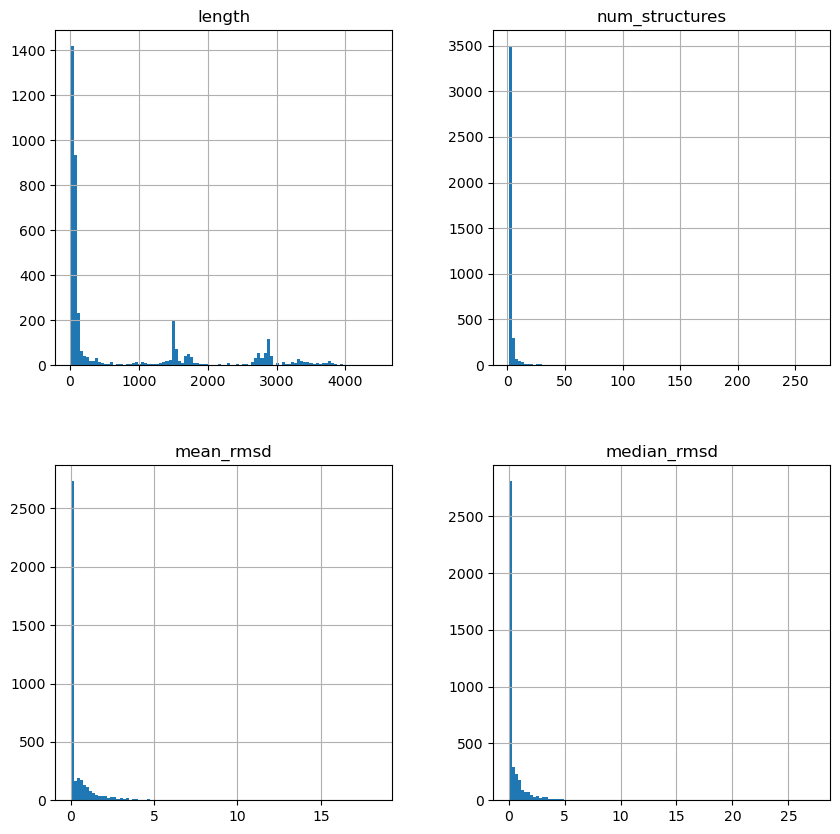

Split: val
Average median RMSD: 1.02 +- 3.19
Median number of structures: 2.00


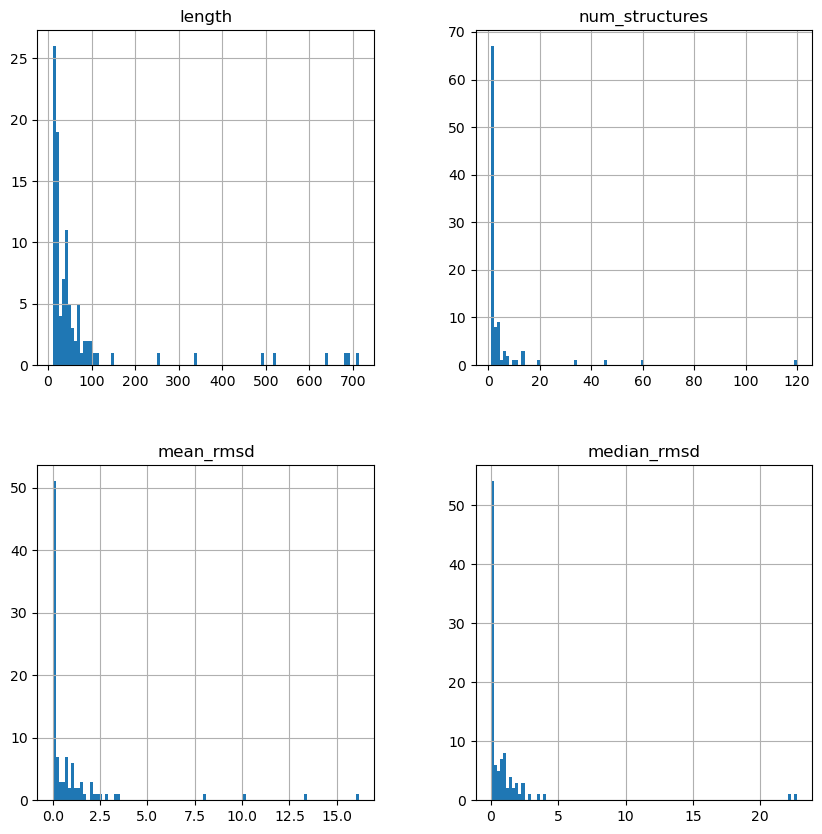

Split: test
Average median RMSD: 0.65 +- 2.35
Median number of structures: 1.00


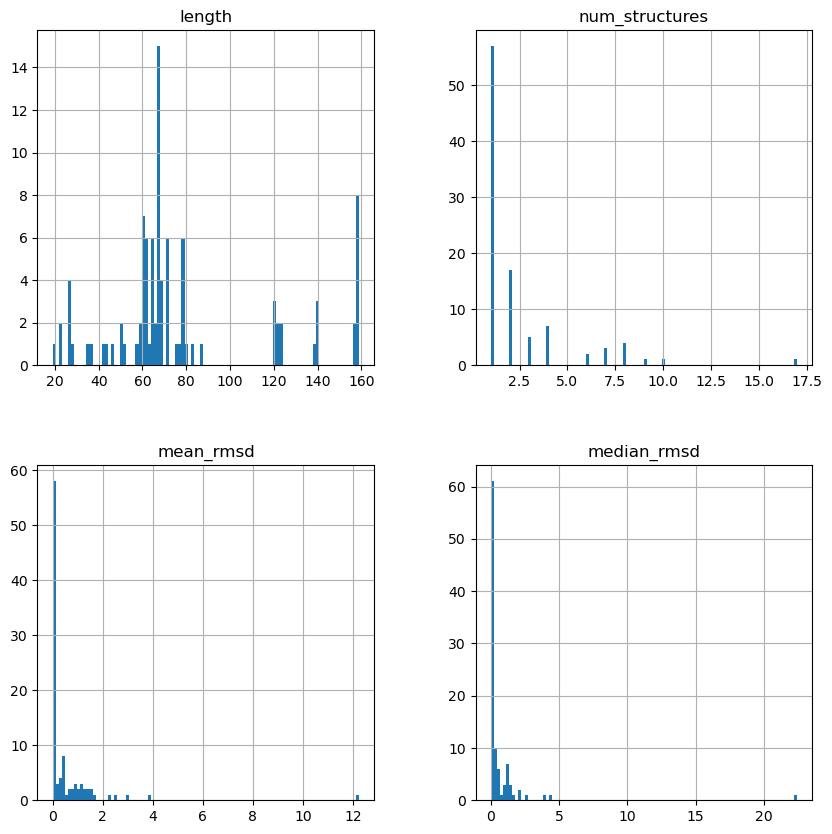

In [37]:
df["split"] = "train"
df.loc[val_idx_list, "split"] = "val"
df.loc[test_idx_list, "split"] = "test"

for split in ["train", "val", "test"]:
    print(f"Split: {split}")
    print(f"Average median RMSD: {df.loc[df.split == split]['median_rmsd'].mean():.2f} +- {df.loc[df.split == split]['median_rmsd'].std():.2f}")
    print(f"Median number of structures: {df.loc[df.split == split]['num_structures'].median():.2f}")
    df.loc[df.split == split].hist(column=["length", "num_structures", "mean_rmsd", "median_rmsd"], figsize=(10, 10), bins=100)
    plt.show()
